<a href="https://colab.research.google.com/github/talitakim14/DeapLearning/blob/main/JenisSusu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle datasets download -d talitamalabar/jenissusu
!mkdir jenissusu
!unzip /content/jenissusu.zip -d /content/jenissusu

 98% 54.0M/55.1M [00:00<00:00, 86.2MB/s]
100% 55.1M/55.1M [00:00<00:00, 79.3MB/s]
Archive:  /content/jenissusu.zip
  inflating: /content/jenissusu/Jenis Susu/susu bubuk/WhatsApp Image 2023-05-09 at 6.30.59 PM.jpeg  
  inflating: /content/jenissusu/Jenis Susu/susu bubuk/WhatsApp Image 2023-05-09 at 6.31.21 PM.jpeg  
  inflating: /content/jenissusu/Jenis Susu/susu bubuk/WhatsApp Image 2023-05-09 at 6.31.24 PM.jpeg  
  inflating: /content/jenissusu/Jenis Susu/susu bubuk/WhatsApp Image 2023-05-09 at 6.31.25 PM.jpeg  
  inflating: /content/jenissusu/Jenis Susu/susu bubuk/WhatsApp Image 2023-05-09 at 6.31.26 PM (1).jpeg  
  inflating: /content/jenissusu/Jenis Susu/susu bubuk/WhatsApp Image 2023-05-09 at 6.31.26 PM.jpeg  
  inflating: /content/jenissusu/Jenis Susu/susu bubuk/WhatsApp Image 2023-05-09 at 6.31.27 PM.jpeg  
  inflating: /content/jenissusu/Jenis Susu/susu bubuk/WhatsApp Image 2023-05-09 at 6.31.34 PM (1).jpeg  
  inflating: /content/jenissusu/Jenis Susu/susu bubuk/WhatsApp Image 

In [3]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [11]:
dataset_path = Path(r'/content/jenissusu')
file_path = list(dataset_path.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [12]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/jenissusu/Jenis Susu/susu uht/WhatsAp...,susu uht
1,/content/jenissusu/Jenis Susu/susu uht/WhatsAp...,susu uht
2,/content/jenissusu/Jenis Susu/susu uht/WhatsAp...,susu uht
3,/content/jenissusu/Jenis Susu/susu uht/WhatsAp...,susu uht
4,/content/jenissusu/Jenis Susu/susu uht/WhatsAp...,susu uht


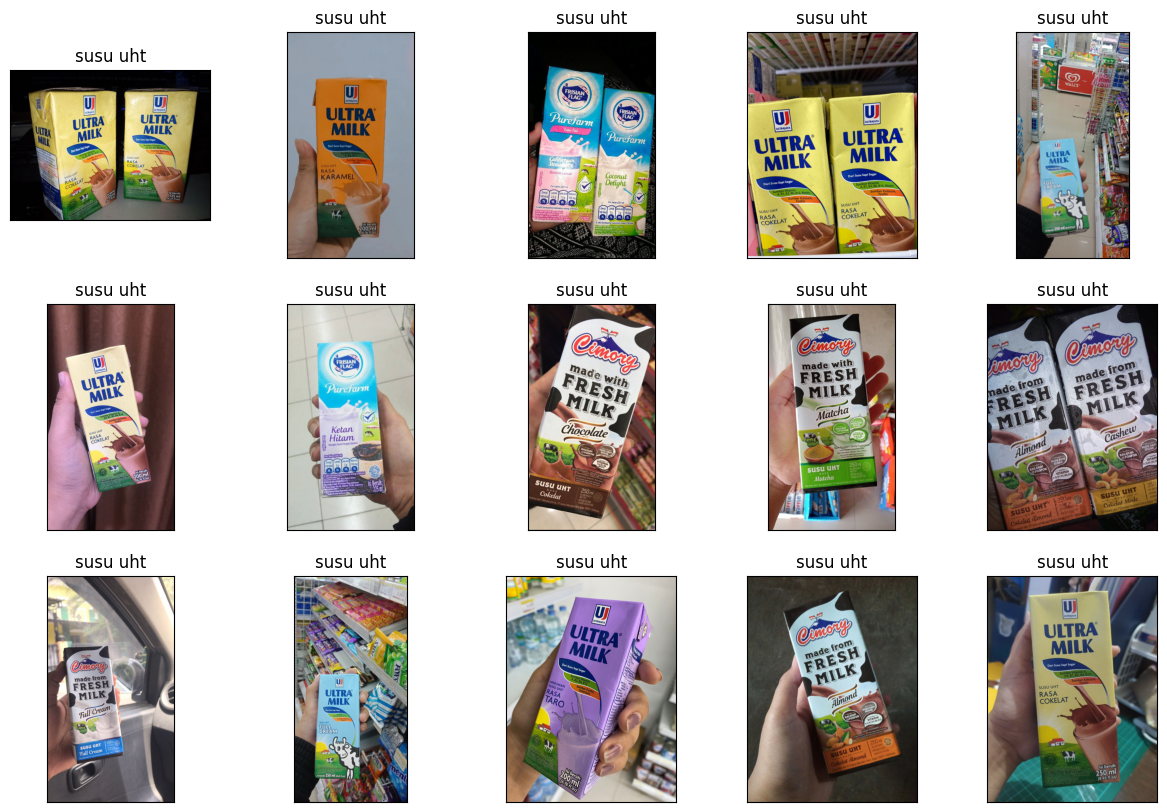

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [14]:
df.label.value_counts()

susu kental manis    101
susu bubuk           101
susu uht             100
Name: label, dtype: int64

In [15]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

susu kental manis    101
susu bubuk           101
susu uht             100
Name: label, dtype: int64

In [16]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [17]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (91, 2)
Shape of validation data (43, 2)


In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

In [19]:
input_shape = (200, 200, 3)

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [21]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
6/6 [==============================] - 48s 9s/step - loss: 1.1290 - accuracy: 0.3333 - val_loss: 1.1131 - val_accuracy: 0.2326
Epoch 2/100
6/6 [==============================] - 33s 5s/step - loss: 1.1062 - accuracy: 0.3155 - val_loss: 1.0876 - val_accuracy: 0.3721
Epoch 3/100
6/6 [==============================] - 35s 5s/step - loss: 1.0790 - accuracy: 0.3690 - val_loss: 1.0193 - val_accuracy: 0.3721
Epoch 4/100
6/6 [==============================] - 33s 5s/step - loss: 1.0061 - accuracy: 0.3929 - val_loss: 0.9119 - val_accuracy: 0.4651
Epoch 5/100
6/6 [==============================] - 35s 6s/step - loss: 0.8858 - accuracy: 0.5833 - val_loss: 0.9192 - val_accuracy: 0.4884
Epoch 6/100
6/6 [==============================] - 33s 5s/step - loss: 0.8315 - accuracy: 0.6071 - val_loss: 0.7045 - val_accuracy: 0.6744
Epoch 7/100
6/6 [==============================] - 35s 6s/step - loss: 0.7736 - accuracy: 0.7024 - val_loss: 0.7871 - val_accuracy: 0.6047
Epoch 8/100
6/6 [==========

In [22]:
model.save('model-1.h5')

In [23]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

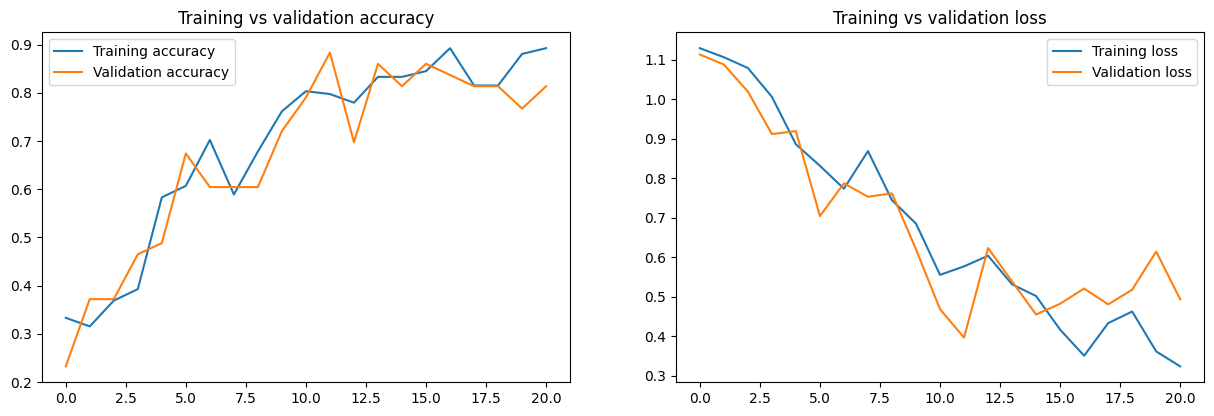

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [25]:
pred = model.predict(test)

3/3 [==============================] - 8s 2s/step


In [26]:
pred = np.argmax(pred, axis=1)

In [27]:
labels = train.class_indices

In [28]:
labels

{'susu bubuk': 0, 'susu kental manis': 1, 'susu uht': 2}

In [29]:
labels = dict((v,k) for k, v in labels.items())

In [30]:
labels

{0: 'susu bubuk', 1: 'susu kental manis', 2: 'susu uht'}

In [31]:
y_pred = [labels[k] for k in pred]

In [32]:
print(classification_report(x_test.label, y_pred))

                   precision    recall  f1-score   support

       susu bubuk       0.77      0.89      0.83        27
susu kental manis       0.75      0.75      0.75        32
         susu uht       0.89      0.78      0.83        32

         accuracy                           0.80        91
        macro avg       0.81      0.81      0.80        91
     weighted avg       0.81      0.80      0.80        91



In [33]:
print(confusion_matrix(x_test.label, y_pred))

[[24  2  1]
 [ 6 24  2]
 [ 1  6 25]]


In [34]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 9s 3s/step - loss: 0.6039 - accuracy: 0.7582
